# Day 08. Exercise 00
# Binary classifier. Logistic regression

## 0. Imports

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 1. Preprocessing

- Получите данные из файла [`checker-timestamp.csv`](https://drive.google.com/file/d/1pooM4cITtG249msX3GK_6W0eEiblzAf5/view?usp=sharing).


- Создайте фрейм данных `df` со столбцами: `date`, `am`, `pm`, `target`, где `date` — дата, `am` — количество коммитов в течение дня до полудня (целое число), `pm` — количество коммитов в течение дня после полудня (целое число), `target` — выходной/рабочий день.

In [69]:
df = pd.read_csv('../data/checker_timestamp.csv')
df

,timestamp
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370
...,...
3202,2020-05-21 20:19:06.872761
3203,2020-05-21 20:22:41.785725
3204,2020-05-21 20:22:41.877806
3205,2020-05-21 20:37:00.129678


In [70]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
# df

In [71]:
# Извлечение даты и времени
df['date'] = df['timestamp'].dt.date
df['time'] = df['timestamp'].dt.time
df['hour'] = df['timestamp'].dt.hour
# df

In [72]:
df['am'] = (df['hour'] < 12).astype(int)  # 1, если коммит сделан до 12:00, иначе 0
df['pm'] = (df['hour'] >= 12).astype(int)  # 1, если коммит сделан после 12:00, иначе 0
# df

### Группируем данные по дате и суммируем количество коммитов до и после полудня для каждого дня

In [73]:
df = df.groupby('date').agg({
    'am': 'sum',
    'pm': 'sum'
}).reset_index()

# df

### Создаем целевой признак target

In [74]:
df['date'] = pd.to_datetime(df['date'])
df['target'] = df['date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)  # 1 - выходной, 0 - рабочий
# df

In [75]:
df[['am', 'pm', 'target']] = df[['am', 'pm', 'target']].astype('int64')

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    35 non-null     datetime64[ns]
 1   am      35 non-null     int64         
 2   pm      35 non-null     int64         
 3   target  35 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.2 KB


## 2. Exploratory analysis

- Создайте график, где «x» — это am, «y» — pm, каждая точка — это день, рабочие дни и выходные должны иметь разные цвета.


- Глядя на график, как вы думаете, будет ли легко классифицировать дни, соответствующие этим двум характеристикам? Впишите свой ответ в ячейку с разметкой в ​​конце этого раздела: «да, легко» или «нет, сложно».

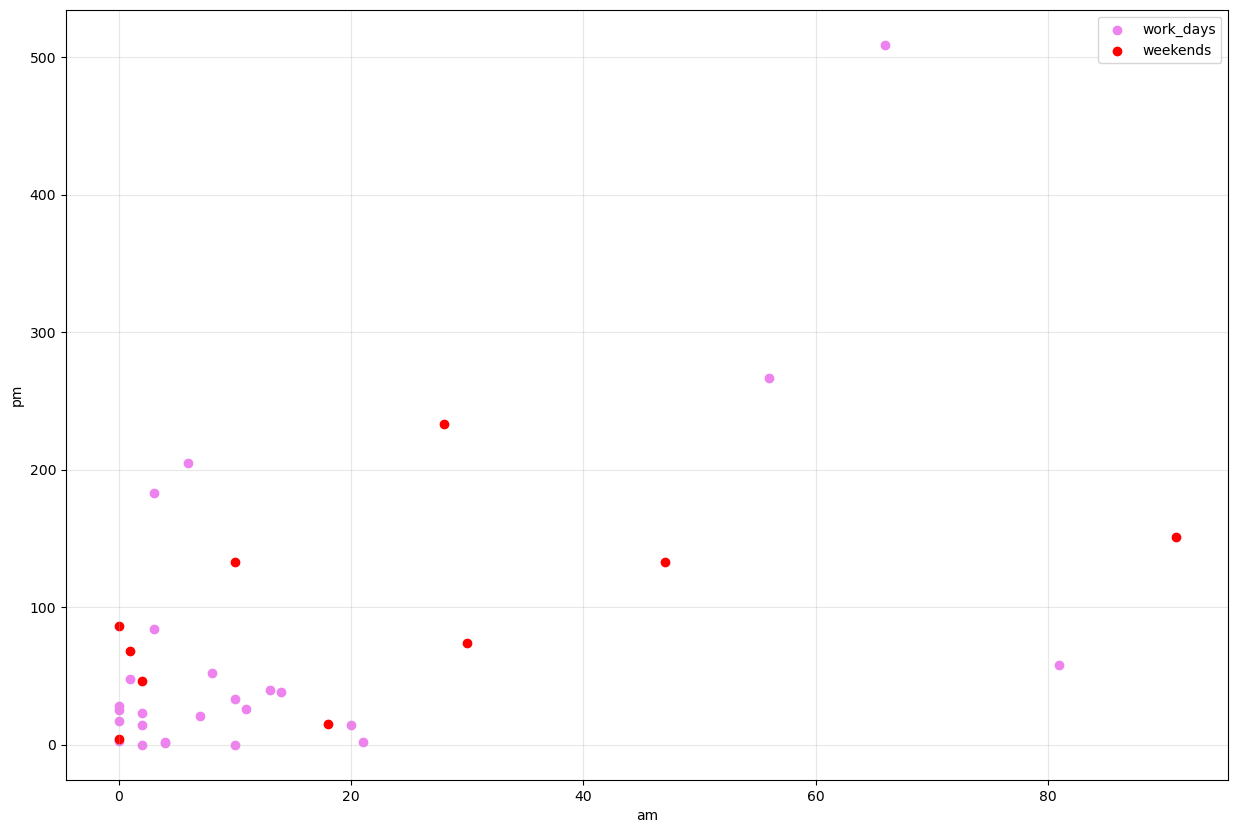

In [77]:
#Распределение коммитов по времени суток (фактические данные)
plt.figure(figsize=(15, 10))

work_days = df[df['target'] == 0]
weekends = df[df['target'] == 1]

plt.scatter(work_days['am'], work_days['pm'], color='violet', label='work_days')
plt.scatter(weekends['am'], weekends['pm'], color='red', label='weekends')

plt.xlabel('am')
plt.ylabel('pm')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


## Глядя на график, будет ли легко классифицировать дни, обладающие этими двумя характеристиками?

### Ответ: нет, это не просто

### Нет явной закономерности или четких границ, чтобы определить в какой период делается больше/меньше комитов

## 3. Logistic regression

- Обучите логистическую регрессию на ваших данных, используя признаки `am` и `pm`, с параметрами: `random_state=21`, `fit_intercept=False`.

- Сделайте предсказания для каждого дня вашего набора данных и добавьте их в ваш dataframe с именем колонки `predict`.

- Сохраните dataframe в файл в подпапке `data` с именем `am_pm.csv`.

- Постройте график аналогичный предыдущему, но цвет точек должен определяться колонкой `predict`.

- Посмотрев на график, как вы считаете, хорошие ли предсказания получились? Поместите ваш ответ в ячейку markdown в конце этой секции: "да, хорошие"; "нет, не хорошие".

In [78]:
x = df[['am', 'pm']] #признаки (am и pm)
y = df['target'] #целевая переменная (target)

## Обучение модели

In [79]:
model = LogisticRegression(random_state=21, fit_intercept=False)
model.fit(x, y)

LogisticRegression(fit_intercept=False, random_state=21)

## Добавляем предсказания модели в DataFrame и сохраняем данные в файл

In [80]:
df['predict'] = model.predict(x) # добавить предсказания

In [81]:
df.to_csv('../data/am_pm.csv', index=False)

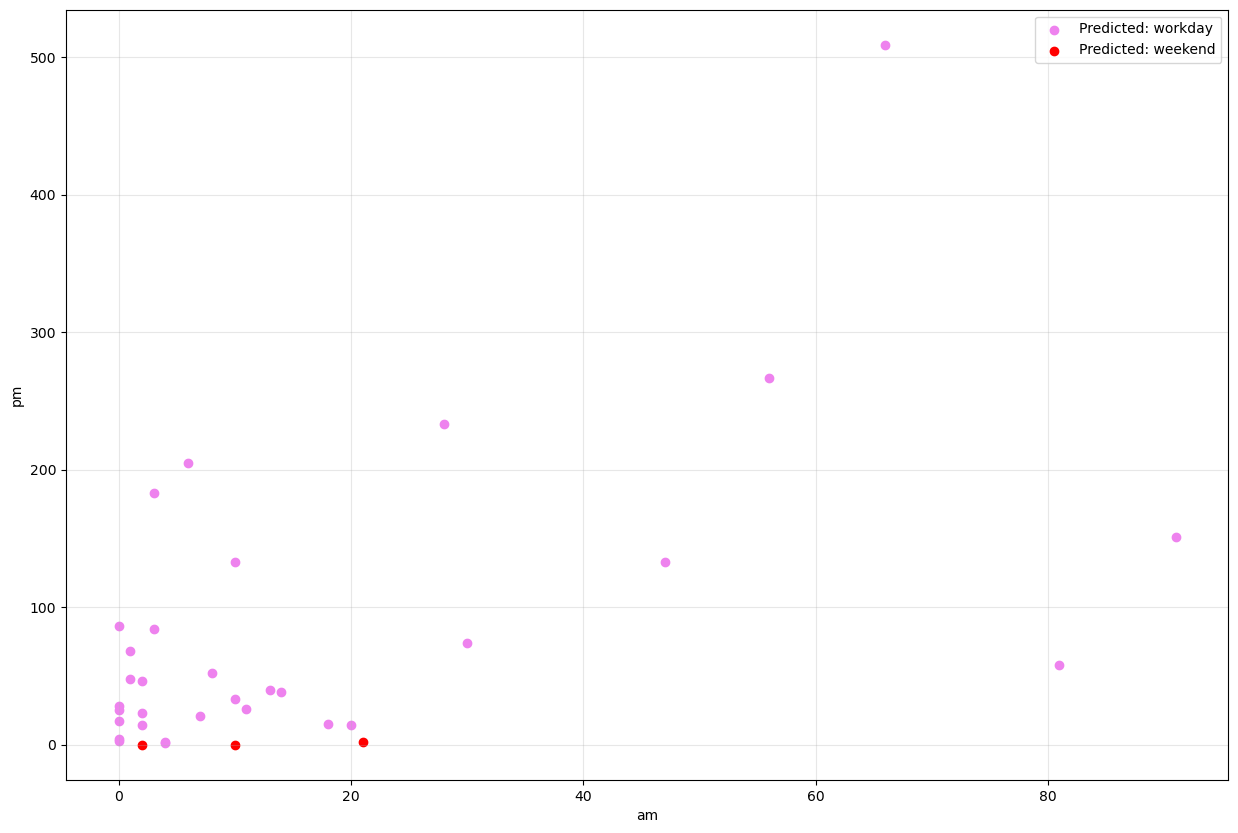

In [82]:
#Предсказание типа дня по коммитам (прогнозируемые данные)
plt.figure(figsize=(15, 10))
pred_work = df[df['predict'] == 0]
pred_weekend = df[df['predict'] == 1]

plt.scatter(pred_work['am'], pred_work['pm'], color='violet', label='Predicted: workday')
plt.scatter(pred_weekend['am'], pred_weekend['pm'], color='red', label='Predicted: weekend')

plt.xlabel('am')
plt.ylabel('pm')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [83]:
accuracy = accuracy_score(y, df['predict'])
print(f'Точность модели: {accuracy:.2f}')

Точность модели: 0.63


## Глядя на график, можно ли сказать, что он даёт хорошие прогнозы?

### Ответ: нет, это плохо
### Модель правильно угадывает тип дня (рабочий/выходной) только в 63% случаев, это очень низкий показатель
### Можно сказать, что она почти что угадывает результат

## 4. Evaluation

- Рассчитайте `accuracy` для ваших предсказаний.

- Рассчитайте `accuracy` для наивного случая, когда каждое ваше предсказание равно значению самого частого класса дня.

- Сравнивая значения точности, как вы считаете, хорошие ли предсказания сделал классификатор? Поместите ваш ответ в ячейку markdown в конце этой секции: "да, хорошие"; "нет, не хорошие".

In [84]:
accuracy = accuracy_score(y, df['predict'])
print(f'Точность модели: {accuracy}')

Точность модели: 0.6285714285714286


In [85]:
naive_pred = [0] * len(df)
naive_accuracy = accuracy_score(y, naive_pred)
print(f'Точность наивного прогноза: {naive_accuracy}')

Точность наивного прогноза: 0.7142857142857143


## Сравнивая точности, считаете ли вы, что классификатор сделал хорошие прогнозы?

## Ответ: Нет, это нехорошо
### Модель показала точность хуже, чем наивный прогноз, что вообще не хорошо!
## Как можно было бы улучшить оценку модели?
### Добавить новые признаки и улучшить данные. В данном случае мы имеем только количество коммитов, что не очень информативно. Решение: добавить новые признаки, например, общее количество комитов и отношение am и pm. Так же можно нормализовать данные.
### Так же использовать другие метрики, кроме Accuracy